In [1]:
import glob
import json
import os
import random as rnd
import shutil

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow import keras
from tqdm import tqdm

from src.utils import (
    DataGenerator,
    euclidean_distance,
    loss,
    make_callbacks,
    make_model,
    plot_history,
)

InteractiveShell.ast_node_interactivity = "all"

In [2]:
(512, 81) > (512, 60)

True

In [3]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 32
        self.img_size = (512, 81)
        self.crop = self.img_size < (512, 81)
        self.n_chanels = 1
        self.n_folds = 6
        self.fold = 2
        self.norm = False
        self.pos_label = 0
        self.n_blocks = 4
        self.emb_len = 1024
        self.kernel_size = (5, 2)
        self.act_fn = "relu"
        self.batch_norm = False
        self.n_epochs = 300
        self.input_shape = (self.img_size[0], self.img_size[1], self.n_chanels)

In [4]:
cfg = CFG()

In [5]:
root_dir = "/app/_data/artist_data/"
mod_dir = "/app/_data/artist_data/models/test_arch/constr_10/"


In [6]:
train = pd.read_csv(os.path.join(root_dir, "train.csv"))


In [7]:
cfg.input_shape

(512, 81, 1)

## train_val_split

In [8]:
gkf = StratifiedGroupKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed)
for n, (train_ids, val_ids) in enumerate(
    gkf.split(
        X=train[["artistid", "artistid_count"]],
        y=train["artistid_count"],
        groups=train["artistid"],
    )
):
    train.loc[val_ids, "fold"] = n

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:885: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=6.
  warnings.warn(


In [9]:
artist_ids = train["artistid"].unique().tolist()
train_set = train[train["fold"] != cfg.fold]["artistid"].unique()
val_set = train[train["fold"] == cfg.fold]["artistid"].unique()
train_data, val_data = {}, {}
for art_id in tqdm(artist_ids):
    new_df = train.query("artistid == @art_id")
    paths = new_df["path"].values.tolist()
    tracks = new_df["trackid"].values.tolist()
    if art_id in train_set:
        train_data[art_id] = {
            "tracks": tracks,
            "paths": paths,
            "count": new_df.shape[0],
        }
    else:
        val_data[art_id] = {"tracks": tracks, "paths": paths, "count": new_df.shape[0]}

100% 18468/18468 [00:44<00:00, 416.17it/s]


## DataGenerator

In [10]:
train_gen = DataGenerator(
    data=train_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=True,
    positive_label=cfg.pos_label,
)
val_gen = DataGenerator(
    data=val_data,
    img_size=cfg.img_size,
    batch_size=cfg.batch_size,
    norm=cfg.norm,
    n_chanels=cfg.n_chanels,
    shuffle=False,
    positive_label=cfg.pos_label,
)

In [11]:
ix = np.random.randint(train_gen.__len__())
imgs, targets = train_gen.__getitem__(ix)

In [12]:
imgs['img1'].shape

(32, 512, 81, 1)

In [13]:
train_gen.positive_label
train_gen.negative_label

0

1

## Build model

In [14]:
# model = make_model(
#     input_shape=cfg.input_shape,
#     n_blocks=cfg.n_blocks,
#     embedding_len=cfg.emb_len,
#     kernel_size=cfg.kernel_size,
#     activation_fn="relu",
#     batch_norm=cfg.batch_norm,
# )

In [15]:
# base_model = keras.applications.EfficientNetV2B0(
#     include_top=False,
#     weights=None,
#     input_shape=cfg.input_shape,
#     pooling=None,
#     include_preprocessing=False,
# )
# input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
# x = base_model(input)
# x = keras.layers.Flatten(name="flatten")(x)
# x = keras.layers.Dense(
#     cfg.emb_len, activation=cfg.act_fn, name=f"dense_{cfg.emb_len}"
# )(x)
# embedding_net = keras.Model(inputs=input, outputs=x, name=f"embedding")

# input_1 = keras.layers.Input(cfg.input_shape, name="img1")
# input_2 = keras.layers.Input(cfg.input_shape, name="img2")
# node1 = embedding_net(input_1)
# node2 = embedding_net(input_2)

# merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
# output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
# model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [16]:
# model = effmod(input_shape=cfg.input_shape, embedding_len=cfg.emb_len)

In [17]:
input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
x = keras.layers.Conv2D(
    4,
    cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_1",
)(input)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_1")(x)

x = keras.layers.Conv2D(
    filters=16,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_2",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_2")(x)

x = keras.layers.Conv2D(
    filters=64,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_3",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_3")(x)

x = keras.layers.Conv2D(
    filters=256,
    kernel_size=cfg.kernel_size,
    activation=cfg.act_fn,
    name="Conv2D_4",
)(x)
x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_4")(x)

# x = keras.layers.Conv2D(
#     filters=256,
#     kernel_size=cfg.kernel_size,
#     activation=cfg.act_fn,
#     name="Conv2D_5",
# )(x)
# x = keras.layers.AveragePooling2D(pool_size=(2, 2), name=f"avg_pool_5")(x)


x = keras.layers.Flatten(name="flatten")(x)
x = keras.layers.Dense(cfg.emb_len, activation=cfg.act_fn, name=f"dense_{cfg.emb_len}")(
    x
)
embedding_net = keras.Model(inputs=input, outputs=x, name=f"embedding")


input_1 = keras.layers.Input(cfg.input_shape, name="img1")
input_2 = keras.layers.Input(cfg.input_shape, name="img2")
node1 = embedding_net(input_1)
node2 = embedding_net(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance)([node1, node2])
output_layer = keras.layers.Dense(1, activation="sigmoid")(merge_layer)
model = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [18]:
callbacks = make_callbacks(
    path=mod_dir,
    monitor="val_loss",
    mode="min",
    reduce_patience=10,
    stop_patience=100,
)
model.compile(
    loss=loss(1),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

In [19]:
if os.path.exists(mod_dir):
    shutil.rmtree(mod_dir)
if os.path.exists(f"/app/.tensorboard/{mod_dir.split('/')[-2]}/"):
    shutil.rmtree(f"/app/.tensorboard/{mod_dir.split('/')[-2]}/")

In [20]:
history = model.fit(
    x=train_gen,
    epochs=cfg.n_epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_data=val_gen,
    shuffle=True,
    steps_per_epoch=len(train_data) // cfg.batch_size,
    validation_steps=len(val_data) // cfg.batch_size,
    validation_freq=1,
    max_queue_size=10,
    workers=10,
    use_multiprocessing=False,
)

Epoch 1/300
478/480 [============================>.] - ETA: 0s - loss: 0.2249 - accuracy: 0.5865 - precision: 0.5478 - recall: 0.9611
Epoch 1: val_loss improved from inf to 0.21329, saving model to /app/_data/artist_data/models/test_arch/constr_10/model.h5
480/480 [==============================] - 45s 84ms/step - loss: 0.2248 - accuracy: 0.5870 - precision: 0.5481 - recall: 0.9610 - val_loss: 0.2133 - val_accuracy: 0.7139 - val_precision: 0.6564 - val_recall: 0.8985 - lr: 0.0010
Epoch 2/300
478/480 [============================>.] - ETA: 0s - loss: 0.2028 - accuracy: 0.7069 - precision: 0.6543 - recall: 0.8857
Epoch 2: val_loss improved from 0.21329 to 0.19562, saving model to /app/_data/artist_data/models/test_arch/constr_10/model.h5
480/480 [==============================] - 40s 83ms/step - loss: 0.2028 - accuracy: 0.7069 - precision: 0.6544 - recall: 0.8860 - val_loss: 0.1956 - val_accuracy: 0.7106 - val_precision: 0.6513 - val_recall: 0.9139 - lr: 0.0010
Epoch 3/300
479/480 [=====

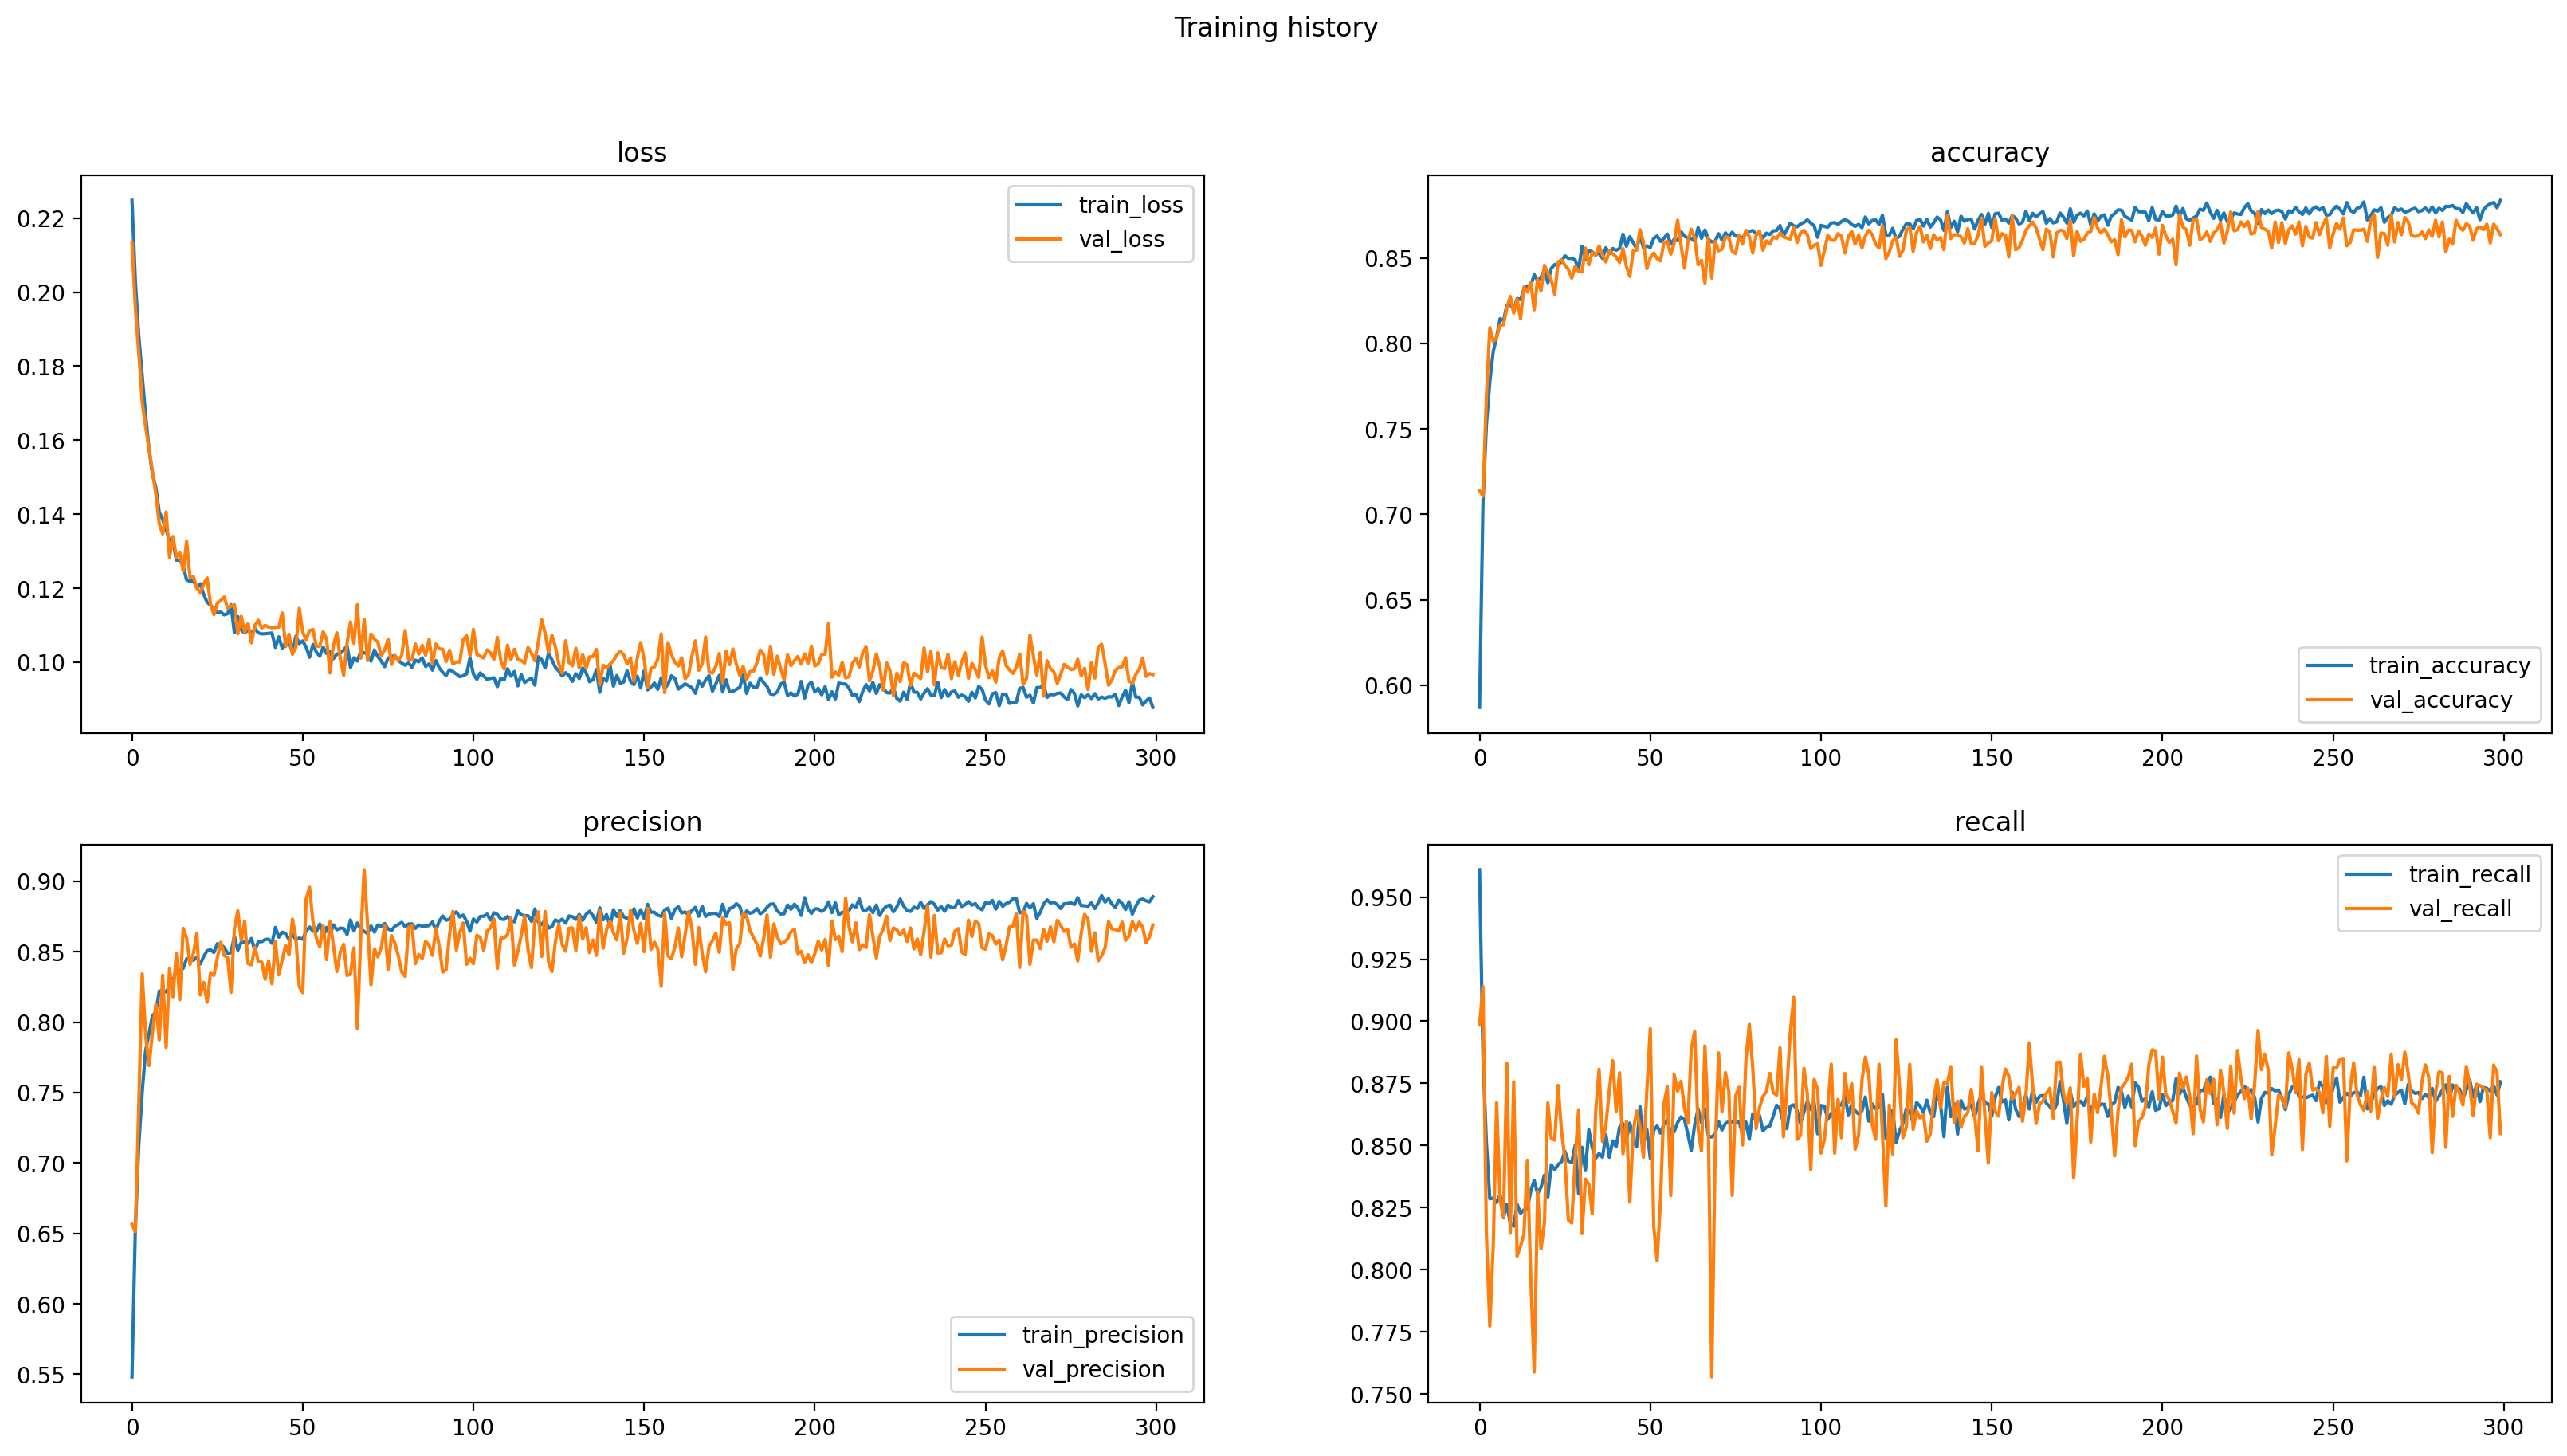

In [21]:
plot_history(history.history)

## save

In [22]:
def save_params(mod_dir, model, history, cfg, loss="constr"):
    train_history = history.history
    min_val_loss_ix = np.argmin(train_history["val_loss"])
    max_acc = train_history["val_accuracy"][min_val_loss_ix]
    max_acc = int(np.round(max_acc * 1000))
    for k in train_history.keys():
        train_history[k] = list(map(float, train_history[k]))
    model.save(
        os.path.join(mod_dir, f"model_{max_acc}.h5"),
    )
    config = {
        "loss": loss,
        "pos_label": cfg.pos_label,
        "history": train_history,
        "norm": cfg.norm,
        "fold": cfg.fold,
        "model": {
            "eff": False,
            "input_shape": cfg.input_shape,
            "n_blocks": cfg.n_blocks,
            "embedding_len": cfg.emb_len,
            "kernel_size": cfg.kernel_size,
            "activation_fn": cfg.act_fn,
            "batch_norm": False,
        },
    }
    with open(os.path.join(mod_dir, "config.json"), "w") as f:
        json.dump(config, f)
    model.save(os.path.join(mod_dir, f"model_{max_acc}"), include_optimizer=False)
    print(
        f'Max_acc = {max_acc/1000}, model saved to {os.path.join(mod_dir, f"model_{max_acc}")}'
    )

In [23]:
save_params(mod_dir, model, history, cfg, loss="constr")

INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/constr_10/model_875/assets


INFO:tensorflow:Assets written to: /app/_data/artist_data/models/test_arch/constr_10/model_875/assets


Max_acc = 0.875, model saved to /app/_data/artist_data/models/test_arch/constr_10/model_875
